

**Machine Learning I (Semester 1 2024)**
# Tutorial Session 6: Resampling & Sampling Methods

*N. Hernitschek*



This Jupyter notebook gives an introduction to resampling and to MCMC.

It is based on code from the textbook

*An Introduction to Statistical Learning: with Applications in Python.*
James Witten, Hastie, Tibshirani; Springer.

which is vailable for free as PDF: https://www.statlearning.com/


***Exercises required for class participation are in <font color='red'>red</font>.***

---
## Contents
* [Bootstrap](#first-bullet)
* [MCMC: Gaussian distribution embedded in a uniform background distribution](#second-bullet)






In lecture 2 we have briefly used a bootstrap resampler and an MCMC. At that time, we had only used them as tool for the Frequentist and Bayesian approach. We will here now work with more complex and realistic examples that also make use of the better understanding we now have about these techniques.

### Importing Packages

We start with importing some of our libraries:

In [1]:
import numpy as np
import astroML
#import emcee
import numpy as np

from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt



## 1. Bootstrap <a class="anchor" id="first-bullet"></a>



### 1.1 Bootstrap with `astroML`

The `astroML` package provides the resampling algorithms bootstrap and jackknife (also see the documentation here
https://www.astroml.org/modules/generated/astroML.resample.bootstrap.html).

We use here the `bootstrap` method which takes the following parameters:

`data`: An $n$-dimensional data array of size `n_samples` by `n_attributes`

`n_bootstraps`: the number of bootstrap samples to compute. Note that internally, two arrays of size `(n_bootstraps, n_samples)` will be allocated. For very large numbers of bootstraps, this can cause memory issues.

`user_statistic`: A function for the statistic to be computed. This should take an array of data of size `(n_bootstraps, n_samples)` and return the row-wise statistics of the data.

In the following, we will calculate the bootstrap uncertainty estimates for the sample standard deviation $\sigma$  and $\sigma_G$. The sample consists of $N = 1000$ values drawn from a Gaussian distribution with $\mu = 0$ and $\sigma = 1$. The bootstrap estimates are based on 10,000 samples.

/home/nhernits/.local/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


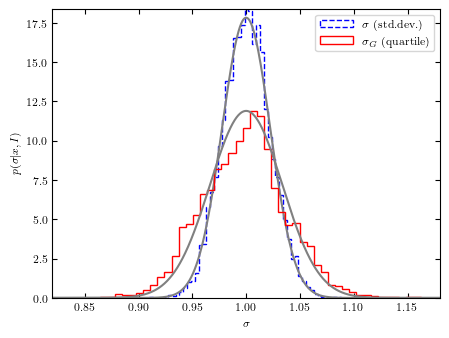

In [2]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

from astroML.resample import bootstrap
from astroML.stats import sigmaG

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

#------------------------------------------------------------
# Compute bootstrap resamplings of data
mu1_bootstrap = bootstrap(data, n,  np.std, kwargs=dict(axis=1, ddof=1))
mu2_bootstrap = bootstrap(data, n, sigmaG, kwargs=dict(axis=1))

#------------------------------------------------------------
# Compute the theoretical expectations for the two distributions
x = np.linspace(0.8, 1.2, 1000)

sigma1 = 1. / np.sqrt(2 * (m - 1))
pdf1 = norm(1, sigma1).pdf(x)

sigma2 = 1.06 / np.sqrt(m)
pdf2 = norm(1, sigma2).pdf(x)

#------------------------------------------------------------
# Plot the results
fig, ax = plt.subplots(figsize=(5, 3.75))

ax.hist(mu1_bootstrap, bins=50, density=True, histtype='step',
        color='blue', ls='dashed', label=r'$\sigma\ {\rm (std. dev.)}$')
ax.plot(x, pdf1, color='gray')

ax.hist(mu2_bootstrap, bins=50, density=True, histtype='step',
        color='red', label=r'$\sigma_G\ {\rm (quartile)}$')
ax.plot(x, pdf2, color='gray')

ax.set_xlim(0.82, 1.18)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')

ax.legend()

plt.show()



### 1.2 Bootstrap with `scikit-learn`

The `scikit-learn` library provides an implementation that will create a single bootstrap sample of a dataset.

The `resample()` scikit-learn function can be used. It takes as arguments the data array, whether or not to sample with replacement, the size of the sample, and the seed for the pseudorandom number generator used prior to the sampling.



(For using bootstrap for cross-validation, look at https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.cross_validation.Bootstrap.html insted.)

For example, we can create a bootstrap that creates a sample with replacement with 4 observations and uses a value of 1 for the pseudorandom number generator.


Unfortunately, the API does not include any mechanism to easily gather the out-of-bag observations (that are not in the bootstrap sample) that could be used as a test set to evaluate a fit model.

At least in the univariate case (= one variable) we can gather the out-of-bag observations using a simple Python list comprehension.

In [3]:
# out of bag observations
oob = [x for x in data if x not in boot]

NameError: name 'boot' is not defined

We can tie all of this together with our small dataset used in the worked example of the prior section.

In [16]:
from sklearn.utils import resample
# data sample
data = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# prepare bootstrap sample
boot = resample(data, replace=True, n_samples=4)#, random_state=1)
print('Bootstrap Sample: %s' % boot)
# out of bag observations
oob = [x for x in data if x not in boot]
print('OOB Sample: %s' % oob)

Bootstrap Sample: [0.4, 0.6, 0.6, 0.2]
OOB Sample: [0.1, 0.3, 0.5]


Running the example prints the observations in the bootstrap sample and those observations in the out-of-bag sample

## 2. MCMC: Gaussian distribution embedded in a uniform background distribution <a class="anchor" id="second-bullet"></a>

We here see how to **model the mixture of a Gaussian distribution with a uniform distribution**. 
We had seen examples for this in the lecture - the most common one in astronomy being spectral lines superimposed upon a background.
 

Let's assume that 
* the location parameter, $\mu$, is known (say from theory) and
* the uncertainties in $x_i$ are negligible compared to $\sigma$.

The likelihood of obtaining a single measurement, $x_i$, can then be written as a probabilistic mixture of *either* the Gaussian *or* the uniform distribution. Hence, we use the **OR Rule** of probability:

$$p(x_i|A,\mu,\sigma,I) = \frac{A}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right) + \frac{1-A}{W}.$$

* Here the background probability is taken to be $0 < x < W$ and 0 otherwise.  
* The feature of interest lies between $0$ and $W$.  
* $A$ and $1-A$ are the relative strengths of the two components, which are obviously anti-correlated.  
* Note that there will be covariance between $A$ and $\sigma$. 

If we adopt a uniform prior in both $A$ and $\sigma$:

$$p(A,\sigma|I) = C, \; {\rm for} \; 0\le A<A_{\rm max} \; {\rm and} \; 0 \le \sigma \le \sigma_{\rm max},$$

then the posterior pdf is given by

$$\ln [p(A,\sigma|\{x_i\},\mu,W)] = \sum_{i=1}^N \ln \left[\frac{A}{\sigma \sqrt{2\pi}} \exp\left( \frac{-(x_i-\mu)^2}{2\sigma^2} \right)  + \frac{1-A}{W} \right].$$

The example below is for $200$ data points with $A=0.5, \sigma=1, \mu=5, W=10$. Specifically, the bottom panel is a result drawn from this distribution and the top panel is the likelihood distribution derived from the data in the bottom panel.

<font color='red'>Please execute the code below.</font> 

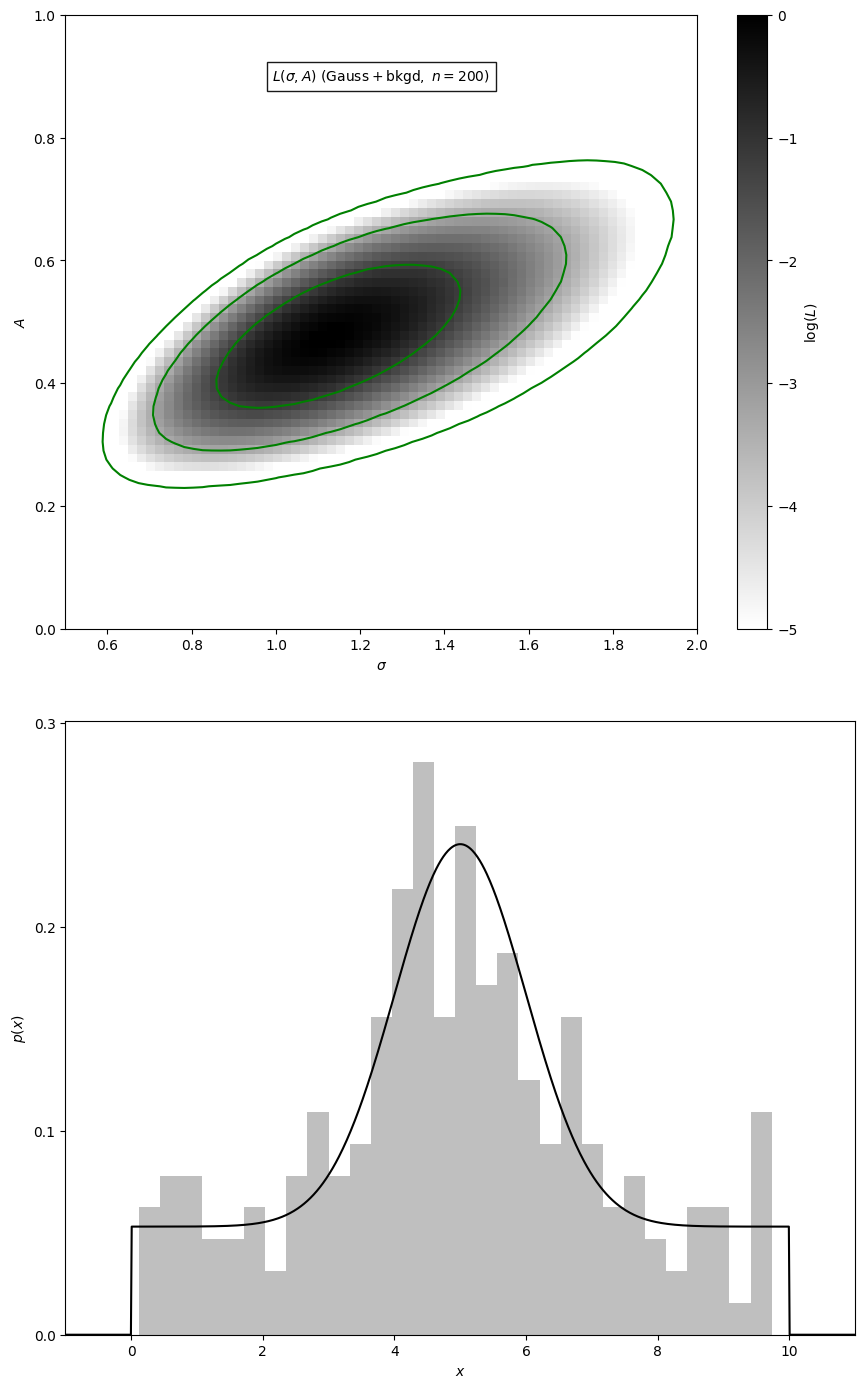

In [6]:
# %load ./code/fig_likelihood_gausslin.py
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from scipy.stats import truncnorm, uniform
from astroML.plotting.mcmc import convert_to_stdev

def gausslin_logL(xi, A=0.5, sigma=1.0, mu=5.0, L=10.0):
    """Equation 5.80: gaussian likelihood with uniform background"""
    xi = np.asarray(xi)

    shape = np.broadcast(sigma, A, mu, L).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return np.sum(np.log(A * np.exp(-0.5 * ((xi - mu) / sigma) ** 2)
                         / (sigma * np.sqrt(2 * np.pi))
                         + (1. - A) / L), 0)

#------------------------------------------------------------
# Define the distribution
np.random.seed(0)
mu = 5.0
sigma = 1.0
L = 10.0
A = 0.5
N = 200

xi = np.random.random(N)
NA = np.sum(xi < A)

dist1 = truncnorm((0 - mu) / sigma, (L - mu) / sigma, mu, sigma)
dist2 = uniform(0, 10)

xi[:NA] = dist1.rvs(NA)
xi[NA:] = dist2.rvs(N - NA)

x = np.linspace(-1, 11, 1000)
fracA = NA * 1. / N

#------------------------------------------------------------
# define the (sigma, A) grid and compute logL
sigma = np.linspace(0.5, 2, 70)
A = np.linspace(0, 1, 70)

logL = gausslin_logL(xi, A[:, np.newaxis], sigma)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 15))
fig.subplots_adjust(bottom=0.07, left=0.11, hspace=0.15, top=0.95)

ax = fig.add_subplot(211)
plt.imshow(logL, origin='lower', aspect='auto',
           extent=(sigma[0], sigma[-1], A[0], A[-1]),
           cmap=plt.cm.binary)
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$A$')

ax.text(0.5, 0.9, r'$L(\sigma,A)\ (\mathrm{Gauss + bkgd},\ n=200)$',
        bbox=dict(ec='k', fc='w', alpha=0.9),
        ha='center', va='center', transform=plt.gca().transAxes)

ax.contour(sigma, A, convert_to_stdev(logL),
           levels=(0.683, 0.955, 0.997),
           colors='g')

ax2 = plt.subplot(212)
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax2.plot(x, fracA * dist1.pdf(x) + (1. - fracA) * dist2.pdf(x), '-k')
ax2.hist(xi, 30, density=True, histtype='stepfilled', fc='gray', alpha=0.5)

ax2.set_ylim(0, 0.301)
ax2.set_xlim(-1, 11)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$p(x)$')
plt.show()

<font color='red'>What are your observations for smaller sample sizes?
What are your observations when you change the shape of the distribution?</font> 

## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* seen resampling techniques within `astroML` and `scikit-learn`, including that `scikit-learn` provides a function that you can use to resample a dataset for the bootstrap method, as well as a function for bootstrap in cross-validation
* seen an example for modeling the mixture of two distributions